#PyFiniteDifferences - Simple waveguide

We simulate a simple squared Waveguide using PyFiniteDifferences in 2 and 3 Dimensions

##Imports
This is where the necessary libraries are imported. Note that we import sympy and the finite difference symbols into the local namespace.

In [1]:
from sympy import *
from pyfinitedifferences.symbols import *
from pyfinitedifferences import finitedifferences
from pyfinitedifferences import settings
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as display
%matplotlib inline
init_printing(use_latex='mathjax')
from time import clock

##Units
This will allow us to use Units in simulation parameters. Here, units are imported into the namespace *u*.

In [2]:
import sympy.physics.units as u
u.keV = 1000 * u.eV

##Symbols
Necessary symbols for constants and variables are defined here for later use. Note the use of latex in the variable names for typesetting.

In [3]:
n_Ge = Symbol("n_\mathrm{Ge}") 
n_Va = Symbol("n_\mathrm{Va}")

E    = Symbol("E",real=True,positive=True)
hbar = Symbol(r"\hslash",real=True)
c    = Symbol("c",real=True)

r_waveguide  = Symbol("r_\mathrm{Waveguide}",real=True,positive=True)
l_waveguide  = Symbol("l_\mathrm{Waveguide}",real=True,positive=True)
prefocus = Symbol("prefocus", real=True, positive=True)
n_inside     = Symbol("n_\mathrm{Inside}",complex=True)
n_outside    = Symbol("n_\mathrm{Outside}",complex=True)

##Settings
The simulation parameters are stored in this object. To define a symbol use the `[]`-operator with a Symbol or Function instance as argument. The final equations are determined by iteratively substituting Symbols with the defined expressions. For better organization we store numeric values seperatly in the member `numeric_values`. Usage:
```
settings[<symbol>] = <expression>
settings.numeric_values[<symbol>] = <number>
```
or to set multiple symbols at once:
```
settings.update({ <symbol_1>:<expression_1>, <symbol_2>:<expression_2>, ... })
settings.numeric_values.update({ <symbol_1>:<number_1>, <symbol_2>:<number_2>, ... })
```
you can also use .n instead of .numeric_values to save some code

In [4]:
setting = settings.AdvancedSettings()

##Solve the parabolic wave equation
We will use the [Crank–Nicolson method](http://en.wikipedia.org/wiki/Crank–Nicolson_method) to numerically solve the parabolic wave equation:

$$
\frac{\partial u}{\partial z} = A \left(\frac{\partial^2 u}{\partial x^2}+\frac{\partial^2 u}{\partial y^2} \right) + F(x,y,z) u, 
$$

with $F(x,y,z)$ and $A$ defined as below.

In [5]:
setting[F] = -I*k/2*(n**2-1);
setting[A] = -I/(2*k);  

display.display(Eq(F,setting[F]))
display.display(Eq(A,setting[A]))

                  ⎛ 2             ⎞ 
             -i⋅k⋅⎝n (x, y, z) - 1⎠ 
F(x, y, z) = ───────────────────────
                        2           

    -i 
A = ───
    2⋅k

##Wave number
We will define the the wavenumber $k$ through the wave energy and set the numeric values for $\hbar$ and $c$.

In [6]:
setting.numeric_values[hbar] = u.hbar
setting.numeric_values[c]    = u.c
setting[k] = E / (hbar*c)

display.display(Eq(k,setting[k]))

        E    
k = ─────────
    \hslash⋅c

##Simulation box
Here the simulation box is defined using $n_x \cdot n_y \cdot n_z$ voxels in $x$, $y$ and $z$ direction (propagation direction is $z$ and for 2D-Simulations $y = 0$). The physical box size is $[-\frac{s_x}{2},\frac{s_x}{2}] \times [-\frac{s_y}{2},\frac{s_y}{2}] \times [0,s_z]$. This results in the step sizes $d_{x_i} = \frac{s_{x_i}}{n_{x_i}}$. 

In [7]:
setting.numeric_values.update({
        nx:300,
        ny:300,
        nz:600,
        
        sx:0.3*u.um,
        sy:0.3*u.um,
        sz:1200*u.um
})

Here we set the unit symbol (for use in in plots) and natural length scale (unit in the numerical simulation) of our simulation by substituting the basic length unit `u.m`. For high numeric precision this should be close to the step size.

In [8]:
setting.length_unit = 'um'
setting.numeric_values[u.m] = u.m/u.um

##Refractive index
Here we define the refractive index $n(x,y,z)$ for a square waveguide with side length $2 \cdot r_\mathrm{Waveguide}$ and length $l_\mathrm{Waveguide}$. 

In [9]:
inside_waveguide = Or(And(abs(x)<=r_waveguide,abs(y)<=r_waveguide),z>=l_waveguide+prefocus, z<= prefocus) 
n_waveguide = Piecewise((n_inside,inside_waveguide),(n_outside,True))

setting.update({
    n:         n_waveguide,
    n_inside:  n_Va,
    n_outside: n_Ge,        
})

display.display(Eq(n,setting.get(n)))

             ⎧n_\mathrm{Va}  for (r_\mathrm{Waveguide} ≥ │x│ ∧ r_\mathrm{Waveg
n(x, y, z) = ⎨                                                                
             ⎩n_\mathrm{Ge}                                                   

uide} ≥ │y│) ∨ z ≥ l_\mathrm{Waveguide} + prefocus ∨ z ≤ prefocus
                                                                 
   otherwise                                                     

##Numeric values
Here numeric values for the simulation are set.

In [10]:
setting.numeric_values.update({
    n_Ge: 1-6.006E-06-6.32E-07*I,
    n_Va: 1,
    
    r_waveguide: 40*u.nm,
    l_waveguide: 800*u.um,
    prefocus: 100*u.um,
    
    E: 12.5*u.keV,
})

##Plot
With numeric values set, we can now plot the simulation box.

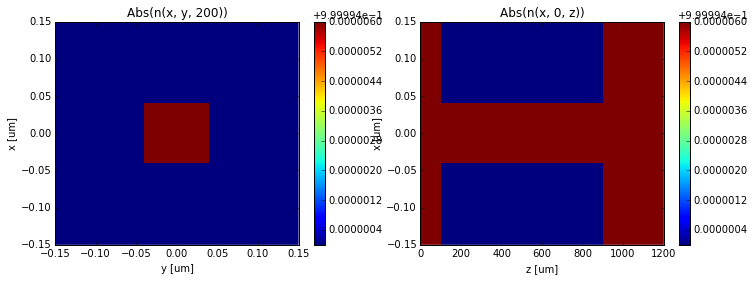

In [11]:
plt.figure(figsize=(12,4))
plt.subplot(121)
finitedifferences.plot_front(abs(n),setting,show=False, z0=200)
plt.subplot(122)
finitedifferences.plot_side(abs(n),setting)

##Boundary conditions
Now boundary conditions are defined. $u_0$ is the field at $z=z_0$, while $u_{0\mathrm{Boundary}}$ is the field at the simulation box edges.

In [12]:
setting[u0] = Number(1)
setting[u0_boundary] = u0 * exp(-I*k*(n_outside-1)*Piecewise((0, z<=prefocus),(l_waveguide,z>=l_waveguide+prefocus),(z,True)))
display.display(Eq(u0,setting[u0]))
display.display(Eq(u0_boundary,setting[u0_boundary]))

u₀(x, y) = 1

                                                                         ⎛⎧   
                                                                         ⎜⎪   
                                           -i⋅k⋅(n_\mathrm{Outside} - 1)⋅⎜⎨l_\
                                                                         ⎜⎪   
                                                                         ⎝⎩   
u_0_\mathrm{Boundary}(x, y, z) = u₀(x, y)⋅ℯ                                   

      0                       for z ≤ prefocus            ⎞
                                                          ⎟
mathrm{Waveguide}  for z ≥ l_\mathrm{Waveguide} + prefocus⎟
                                                          ⎟
      z                           otherwise               ⎠
                                                           

##Finite difference solver 1D
Create the solver using the settings and run a 1D simulation. This will return a data array with amplitudes shape (nx, nz)

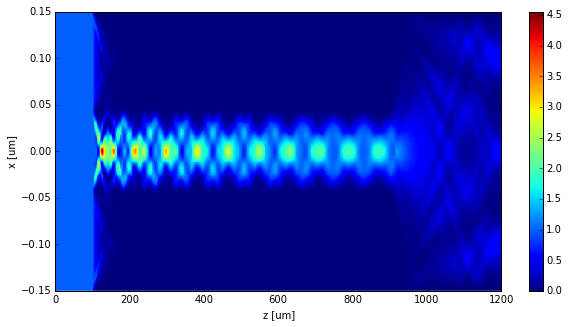

In [13]:
solver = finitedifferences.Solver1D(setting)
data = solver.run()
finitedifferences.plot_side(np.abs(data)**2,setting,size=(10,5))

In [14]:
print(data[setting.get_x_index(0*u.um),setting.get_z_index(200*u.um)])

(0.961258044893+0.50626885806j)


You can save your field using:

In [15]:
np.savetxt("dataExample/Example1DField.dat", data)

Or just the data in some boundaries:

In [16]:
xmin = -10*u.nm
xmax = 10*u.nm
zmin = 0*u.um
zmax = 1200*u.um

np.savetxt("dataExample/Example1DField_2.dat", data[setting.get_x_index(xmin):setting.get_x_index(xmax), setting.get_z_index(zmin):setting.get_z_index(zmax)])

##Finite difference solver 2D
Create the solver using the settings and run a 2D simulation. When calling Solver2D.run() be sure to have enough memory available as this will create a 3-Dimensional complex array of size $n_x \cdot n_y \cdot (n_z+1) / \mathrm{downscale}^3$. Otherwise we could run the simulation manually using the Solver2D.step() and Solver2D.get_field() methods. We integrate the intensity along the y-axis and plot the field.
This will return a array shape (nx, ny, nz)

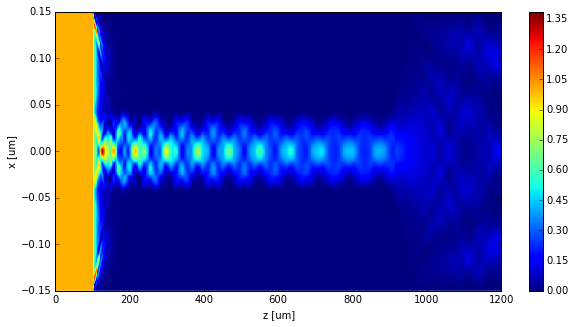

In [17]:
solver = finitedifferences.Solver2D(setting)
data = solver.run()
finitedifferences.plot_side(np.sum(np.abs(data)**2/setting.n[ny],axis=1),setting,size=(10,5))

Or plot the a cut at a specific $y$-value (which a cut through the data at $y_i = ny/2 + y/dy$).

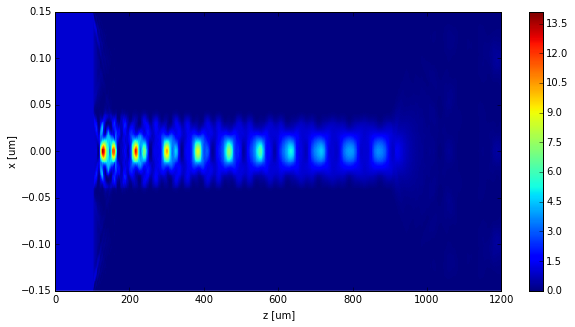

In [47]:
finitedifferences.plot_side(np.abs(data[:,setting.get_y_index(0*u.um),:])**2,setting,size=(10,5))

We can also plot the field for a specific $z$-value (which is a cut through the data at $z_i = \frac{z}{dz}$).

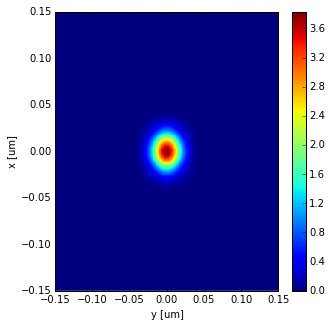

In [48]:
finitedifferences.plot_front(np.abs(data[:,:,setting.get_z_index(l_waveguide)])**2,setting,size=(5,5))